# Wine Forecasting

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts.datasets import WineDataset
from darts.utils.statistics import plot_acf, plot_pacf, plot_hist, plot_residuals_analysis, check_seasonality, seasonal_decompose

from darts.metrics import mae, mape, mase, r2_score
from darts.models import (
    NaiveDrift,
    NaiveSeasonal,
    ARIMA,
    AutoARIMA,
    ExponentialSmoothing,
    Prophet,
    Theta
)

import warnings
warnings.filterwarnings('ignore')

In [2]:
wine = WineDataset().load()

## Data Description 

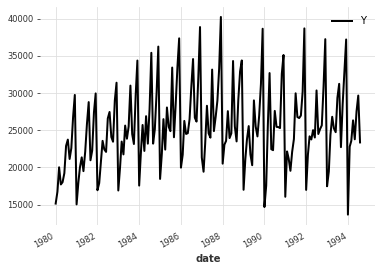

In [13]:
wine.plot()

In [14]:
for i in range(2, 25):
    is_seasonal, m = check_seasonality(wine, m=i)
    if is_seasonal:
        print(f"Dataset is seasonal with term {m}")

Dataset is seasonal with term 4
Dataset is seasonal with term 8
Dataset is seasonal with term 12
Dataset is seasonal with term 16
Dataset is seasonal with term 20


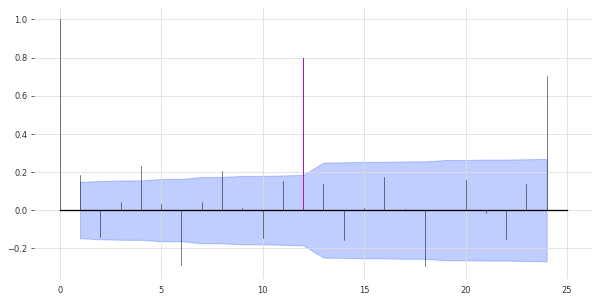

In [15]:
plot_acf(wine, m=12)

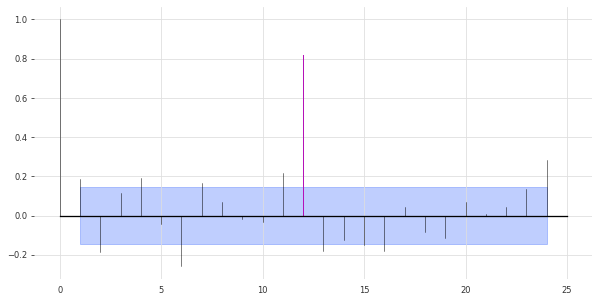

In [16]:
plot_pacf(wine, m=12)

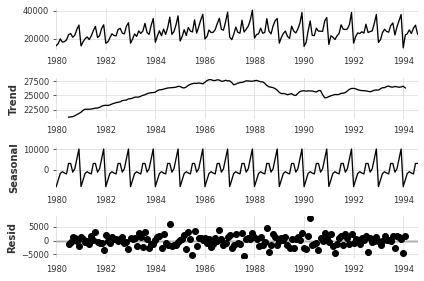

In [17]:
seasonal = seasonal_decompose(wine.pd_dataframe())
_ = seasonal.plot()

## Model Choosing

In [19]:
train, test = wine.split_before(pd.Timestamp('19930101'))

In [24]:
models = (
    NaiveDrift(),
    NaiveSeasonal(K=4),
    NaiveSeasonal(K=12),
    AutoARIMA(),
    ExponentialSmoothing(seasonal_periods=12),
    Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True
    ),
    Theta(seasonality_period=12)
)   

In [25]:
best_model = None
initial_error = np.inf

for model in models:
    backtest_errors = model.backtest(
        train, start=0.5, stride=6, forecast_horizon=12, metric=mape
    )
    model_error = np.mean(backtest_errors)
    print(model, ':', model_error)
    
    if model_error < initial_error:
        best_model = model

Naive drift model : 25.85912964248484
Naive seasonal model, with K=4 : 18.309228567263784
Naive seasonal model, with K=12 : 9.241890275522168
Auto-ARIMA : 17.58327357160689
Exponential smoothing : 9.319658946329223
Prophet : 9.996032819527619
Theta(2) : 9.188517561563136


## Parameter Tuning

In [37]:
theta_grid = {'theta': np.linspace(-10, 10, 10),
              'seasonality_period': [12]}
theta_model = Theta()

theta_model = theta_model.gridsearch(
    parameters=theta_grid,
    series=train,
    stride=1,
    forecast_horizon=12,
    n_jobs=-1,
)[0]

[2021-11-23 17:58:13,014] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'theta': 1.1111111111111107, 'seasonality_period': 12}
[2021-11-23 17:58:13,014] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'theta': 1.1111111111111107, 'seasonality_period': 12}
INFO:darts.models.forecasting.forecasting_model:Chosen parameters: {'theta': 1.1111111111111107, 'seasonality_period': 12}


## Performance Evaluation

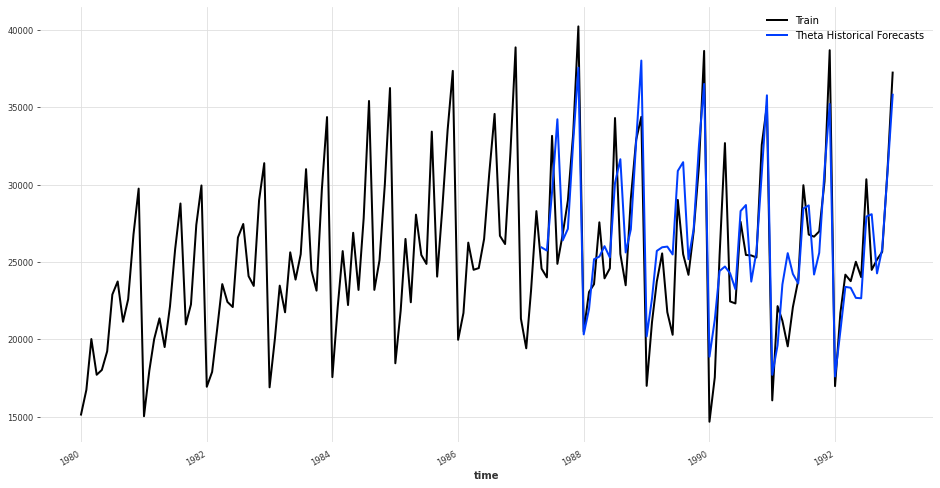

In [43]:
historical = theta_model.historical_forecasts(
    train,
    stride=1,
    forecast_horizon=12,
)
fig, ax = plt.subplots(figsize=(16, 8))
train.plot(label='Train')
historical.plot(label='Theta Historical Forecasts')
plt.show()

In [54]:
backtest_errors = theta_model.backtest(
    train,
    stride=1,
    forecast_horizon=12,
    metric=mape,
    reduction=None
)

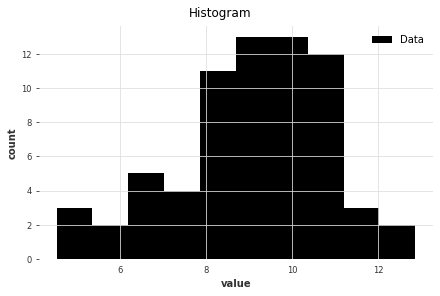

In [55]:
plot_hist(backtest_errors)

## Predictions 

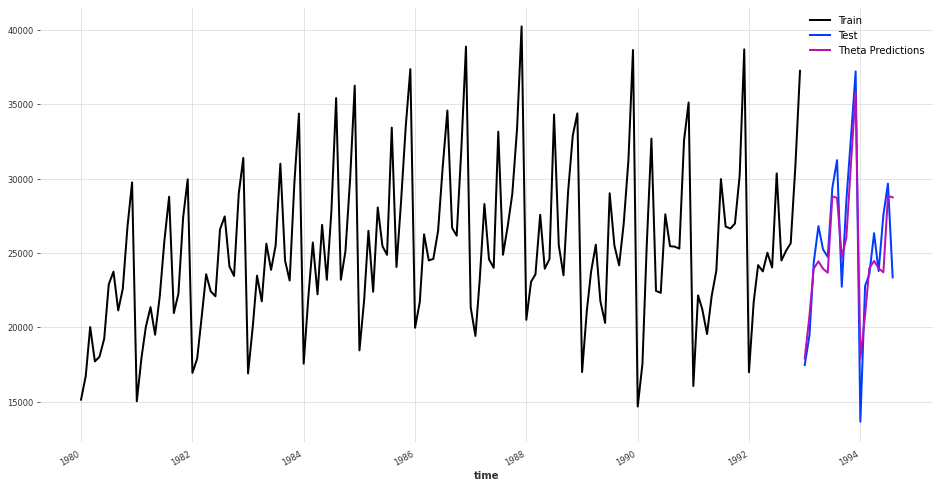

In [46]:
theta_model.fit(train)
preds = theta_model.predict(len(test))

fig, ax = plt.subplots(figsize=(16, 8))
train.plot(label='Train')
test.plot(label='Test')
preds.plot(label='Theta Predictions')
plt.show()

## Conclusions